In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
pd.set_option('display.max_columns', None)
#from mpl_toolkits.mplot3d import Axes3D
import os
import warnings
warnings.filterwarnings('ignore')

import scipy.io
from scipy.fft import fft, ifft, fftfreq

In [2]:
os.listdir('archive')

['part_12.mat',
 'part_5.mat',
 'part_4.mat',
 'part_11.mat',
 'part_6.mat',
 'part_7.mat',
 'part_10.mat',
 'part_3.mat',
 'part_2.mat',
 'part_1.mat',
 'Samples',
 'part_9.mat',
 'part_8.mat']

In [3]:
#error function
from sklearn.metrics import mean_squared_error 
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [4]:
test_data = scipy.io.loadmat(f'archive/part_{1}.mat')['p']

In [5]:
test_data.shape

(1, 1000)

In [6]:
type(test_data)

numpy.ndarray

In [7]:
print(f"Total test data: {len(test_data[0])}")
print(f"Number of readings in each sample(column): {len(test_data[0][0])}")
print(f"Number of samples in each reading(ECG): {len(test_data[0][0][2])}")

temp_mat = test_data[0, 999]
temp_length = temp_mat.shape[1]
sample_size = 125


print(temp_length)
print((int)(temp_length/sample_size))

Total test data: 1000
Number of readings in each sample(column): 3
Number of samples in each reading(ECG): 61000
9000
72


In [8]:
temp_mat

array([[  1.59139785,   1.73509286,   1.90420332, ...,   1.38611926,
          1.36852395,   1.35288368],
       [ 81.81387466,  79.61588996,  78.05287863, ..., 118.49579696,
        116.05359175, 113.61138654],
       [  0.79980469,   0.79980469,   0.79492188, ...,   0.875     ,
          0.87011719,   0.875     ]])

In [9]:
ppg=[]
for i in range(1000):
    temp_mat= test_data[0,i]
    temp_length= temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ppg= temp_mat[0, j*sample_size:(j+1)*sample_size]
        ppg.append(temp_ppg)

In [10]:
ecg = []
bp = []
sbp = [] #Systolic Blood Pressure
dbp = [] #Diastolic Blood Pressue
size = 125 #sample size

for i in range(1000):
    temp_mat = test_data[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ecg = temp_mat[2, j*size:(j+1)*size]
        temp_bp = temp_mat[1, j*size:(j+1)*size]
        
        max_value = max(temp_bp)#sbp
        min_value = min(temp_bp)#dbp
        
        sbp.append(max_value)
        dbp.append(min_value)
        ecg.append(temp_ecg)
        bp.append(temp_bp)

In [11]:
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (32061000, 1)
 ECG_shape: (32061000, 1)
 BP_shape: (32061000, 1)
Systolic-BP_shape: (256488, 1),
 Diastolic-BP_shape: (256488, 1)


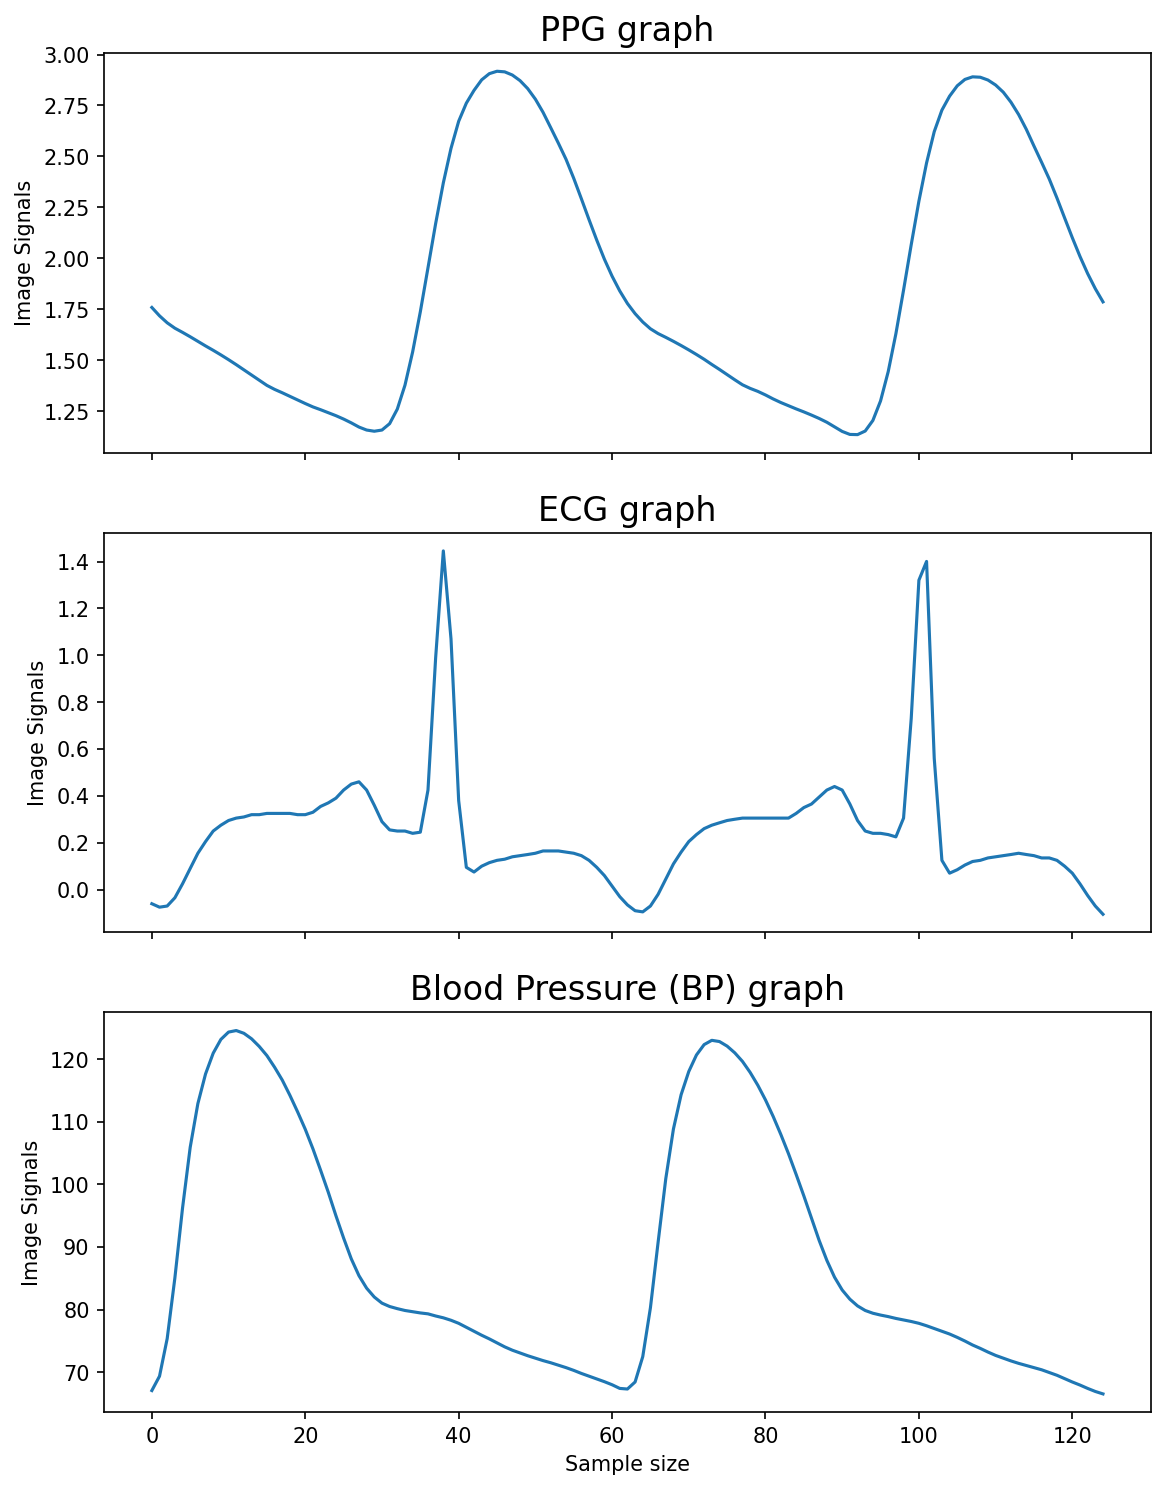

In [12]:
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True, dpi= 150)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Image Signals')
ax[0].plot(ppg[:125])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Image Signals')
ax[1].plot(ecg[:125])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Image Signals')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:125])

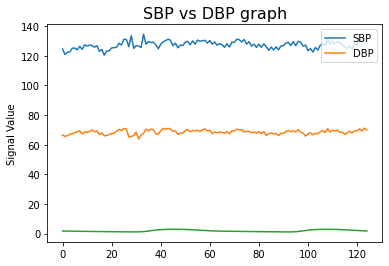

In [13]:
plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])

plt.plot(ppg[:125])

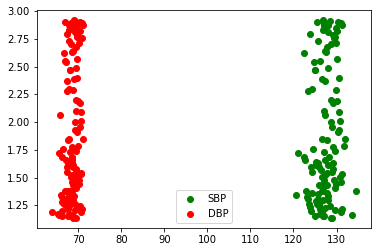

In [14]:
plt.scatter(sbp[:125],ppg[:125], color= 'green')
plt.scatter(dbp[:125],ppg[:125],color= 'red')
plt.legend(['SBP','DBP'])

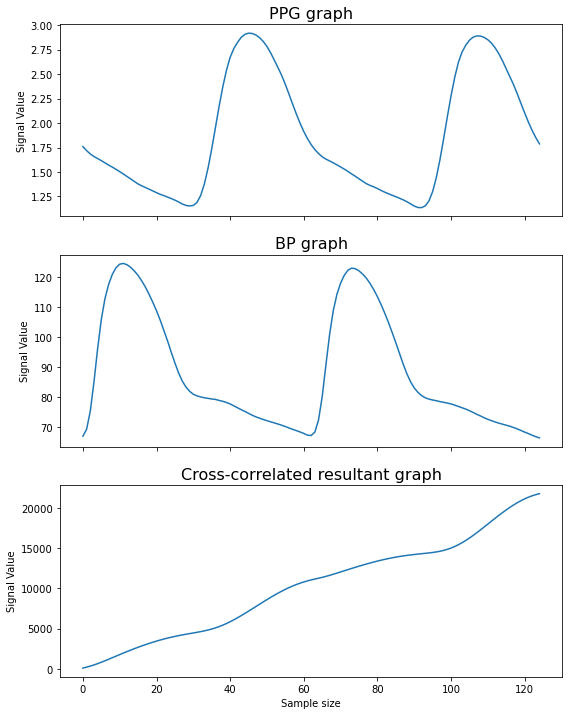

In [15]:
#Signal Processing
cross_corr = np.convolve(ppg[:125].squeeze(), bp[:125].squeeze(), mode='full')

fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('BP graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(bp[:125])

ax[2].set_title('Cross-correlated resultant graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(cross_corr[:125])

In [16]:
def array_fft(signal, size, zoom_ratio=1):

    sample_signal = signal
    sample_length = sample_signal.size
    print(f"sample_length {sample_length}")
    
    
    med_ind = (sample_length // 2)
    print(f"med_ind {med_ind}")
    sampling_size = size
    sample_space = 1 / sampling_size
    t = np.linspace(0, 0+(sample_length*sample_space), sample_length)
    xf = fftfreq(t.size, sample_space)
    yf = (fft(sample_signal) / sample_length)[1:]
    yfm = np.abs(yf)

    zoom_freq = int(med_ind * zoom_ratio)
    xfr = xf[:med_ind][:zoom_freq]
    yfmr = yfm[:med_ind][:zoom_freq] 
    print(f"xfr_length {xfr.size}")
    max_ind = np.argmax(yfmr)
    print(f"max_freq {xfr[max_ind]}, minute_freq {xfr[max_ind] * 60}, max_amp {yfmr[max_ind]}")
    
    
    plt.figure(figsize=[15,12])
    plt.subplot(211)
    plt.plot(sample_signal[:3*size])

    plt.subplot(212)
    plt.plot(xfr, yfmr)
    


    plt.show()

sample_length 32061000
med_ind 16030500
xfr_length 11221350
max_freq 0.0816685380992483, minute_freq 4.900112285954898, max_amp [1.24823151e-07]


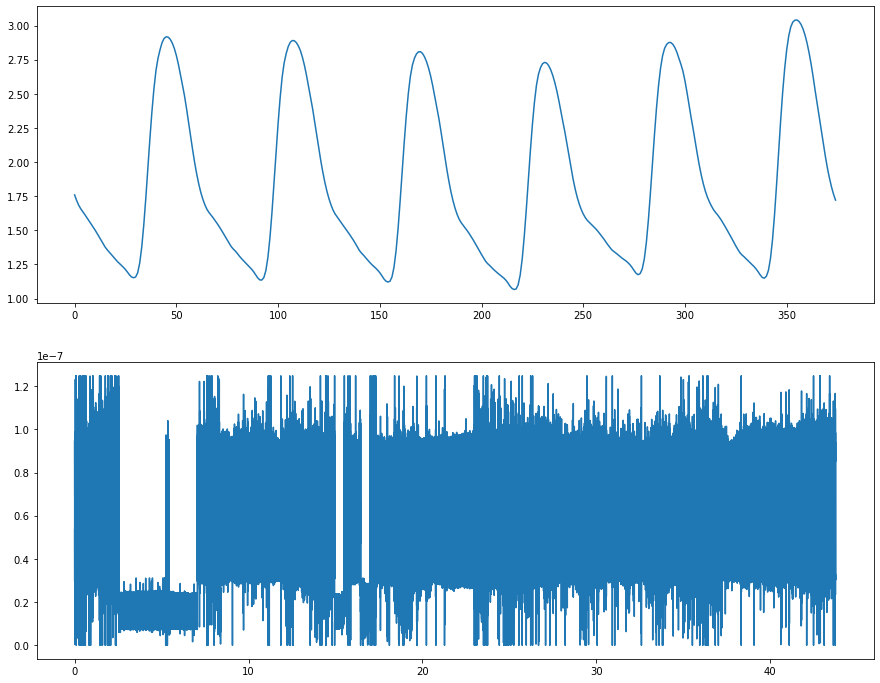

In [17]:
array_fft(ppg, size=125, zoom_ratio=0.7)

sample_length 32061000
med_ind 16030500
xfr_length 11221350
max_freq 32.95308942328686, minute_freq 1977.1853653972116, max_amp [1.40357444e-07]


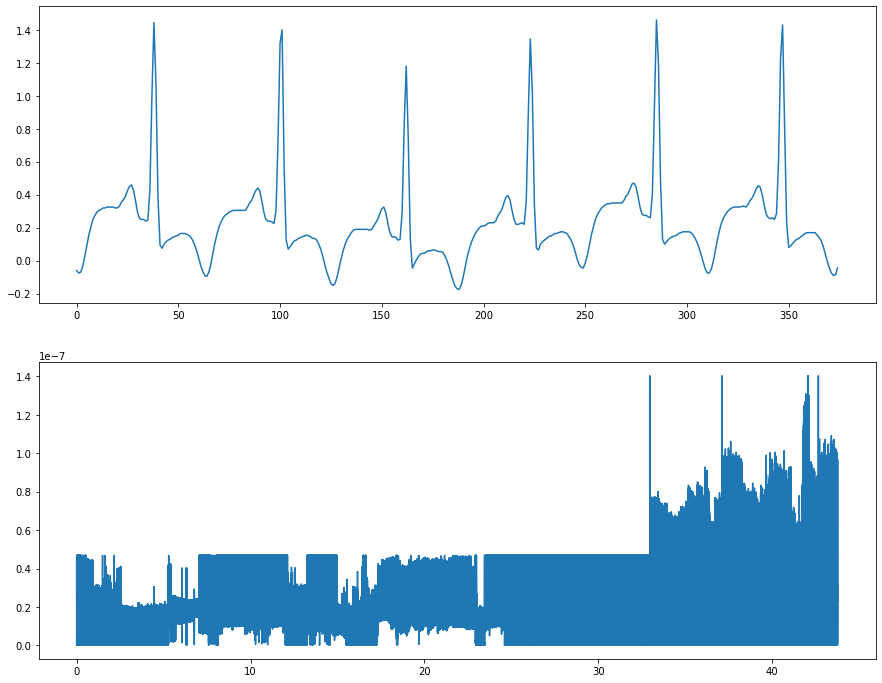

In [18]:
array_fft(ecg, size=125, zoom_ratio=0.7)

Let's Train The Model

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test= train_test_split(ppg, bp, test_size= 0.3)

In [20]:
#Kfold cross-validation

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold


folds = KFold(n_splits=5, shuffle=False)
scores = []
for i, (train_index, val_index) in enumerate(folds.split(X_train, Y_train)):
    train_data, target = X_train[train_index], Y_train[train_index]
    validation_data, val_target = X_train[val_index], Y_train[val_index]
    
    model = LinearRegression()
    model.fit(train_data, target)
    
    
    val_predictions = model.predict(validation_data)
    error = rmse(val_target, val_predictions)
    scores.append(error)
    print(f'Fold {i} RMSE: {error}')
print(f'Average RMSE over 5 folds: {np.mean(scores)}')

Fold 0 RMSE: 27.345899100918295
Fold 1 RMSE: 27.338609989830026
Fold 2 RMSE: 27.35691512801445
Fold 3 RMSE: 27.34684247515113
Fold 4 RMSE: 27.34406559450155
Average RMSE over 5 folds: 27.34646645768309


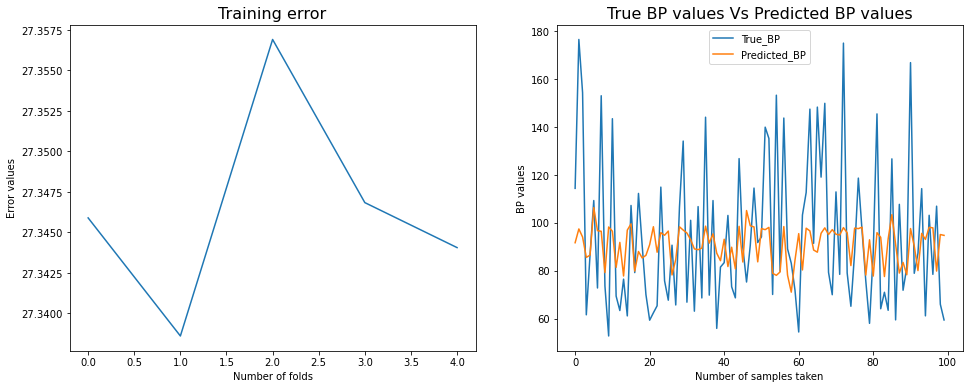

In [21]:
#Let's plot a graph
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].set_title("Training error", fontsize= 16)
ax[0].set_xlabel('Number of folds')
ax[0].set_ylabel('Error values')
ax[0].plot(scores)

# Visualize predicted BP and the True BP
ax[1].set_title("True BP values Vs Predicted BP values", fontsize= 16)
ax[1].set_xlabel('Number of samples taken')
ax[1].set_ylabel('BP values')
ax[1].plot(val_target[:100]) #only plotting 100 samples
ax[1].plot(val_predictions[:100])
ax[1].legend(['True_BP', 'Predicted_BP'])

In [22]:
# Let's calculate the prediction score
test_predictions = model.predict(X_test[:1000000])
test_error = rmse(Y_test[:1000000], test_predictions)
print(f'Error on test set predictions: {test_error}')

Error on test set predictions: 27.34247733265144


In [23]:
# Neural Network Model

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers



def Model(input_dim, activation, num_class):
    model = Sequential()

    model.add(Dense(1024, input_dim = input_dim))
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(512)) 
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(64))    
    model.add(Activation(activation))
    model.add(Dropout(0.25))

    model.add(Dense(num_class))    
    model.add(Activation('linear'))
    
    model.compile(loss='Huber',
                  optimizer=optimizers.Adam(lr = 0.001),
                  metrics=['MeanAbsoluteError']
                 )
    return model

In [24]:
input_dim = X_train.shape[1]
activation = 'relu'
classes = 1
model = Model(input_dim=input_dim, activation=activation, num_class=classes)
model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              2048      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)           

2022-03-13 06:28:47.898348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-13 06:28:47.898755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


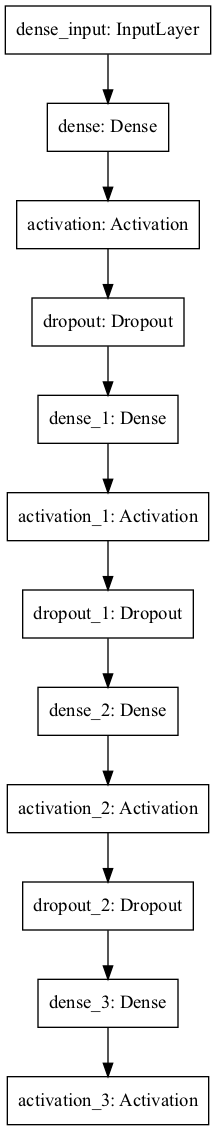

In [25]:
tf.keras.utils.plot_model(model)

In [26]:
#Let's train our model

history = model.fit(X_train[:1000000], # using the first 1million rows for speed.
                    Y_train[:1000000].squeeze(),
                    epochs=5,
                    batch_size=128,
                    verbose = 1
                   )

2022-03-13 06:28:48.735902: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-13 06:28:48.738876: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2022-03-13 06:28:49.362838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7813/7813 [==============================] - 51s 6ms/step - loss: 20.1049 - mean_absolute_error: 20.5991
Epoch 2/5
7813/7813 [==============================] - 50s 6ms/step - loss: 19.1125 - mean_absolute_error: 19.6063
Epoch 3/5
7813/7813 [==============================] - 50s 6ms/step - loss: 19.0641 - mean_absolute_error: 19.5579
Epoch 4/5
7813/7813 [==============================] - 50s 6ms/step - loss: 19.0361 - mean_absolute_error: 19.5300
Epoch 5/5
7813/7813 [==============================] - 50s 6ms/step - loss: 19.0201 - mean_absolute_error: 19.5138


In [31]:
# Let's now predict our model
nn_predictions = model.predict(X_test[:1000000])
error = rmse(Y_test[:1000000], nn_predictions)
print(f'Neural Net RMSE: {error}')

Neural Net RMSE: 26.698837177803032


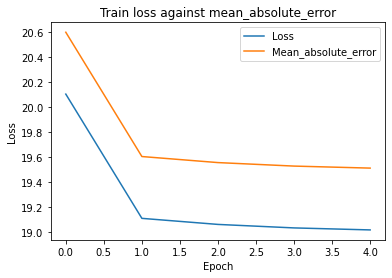

In [28]:
plt.title('Train loss against mean_absolute_error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Loss', 'Mean_absolute_error'])

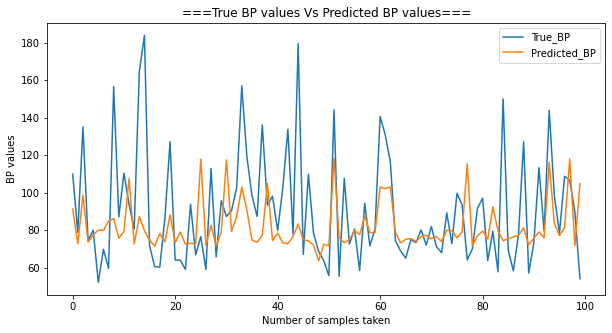

In [29]:
plt.figure(figsize= (10,5))
plt.title("===True BP values Vs Predicted BP values===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(Y_test[:100])
plt.plot(nn_predictions[:100])
plt.legend(['True_BP', 'Predicted_BP'])